In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

def change_timeframe(data:object, timeframe:int):
        new_df = data.groupby(pd.Grouper(freq=f'{timeframe}min', origin='start', label='right')).agg({'close_price':'last', 'high_price':'max', 'low_price':'min',
                                                                                           'open_price':'first', 'taker_buy_base_asset_volume':'sum',
                                                                                           'open_time':'first', 'volume':'sum', 'close_time':'last', 'trades':'sum'})
        new_df.dropna(inplace=True)        
        return new_df

def clean_data():
        # MA, OBV, Stochastic

        # Loading the data
        path = 'resources/dataset/test_db.csv' # 'resources/dataset/2018-2022_1min.csv' # 'resources/dataset/daily_15min.csv' # 
        df = pd.read_csv(path)

        df.columns = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price', 'volume',
                        'close_time', 'quote_asset_volume', 'trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

        # Creating and Converting columns
        df = pd.concat([df[['close_price', 'high_price', 'low_price']], df.drop(['close_price', 'high_price', 'low_price'], axis=1)], axis=1)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df.set_index('open_time', inplace=True, drop=False)
        df = df[14:]

        # Making 15 minutes graph
        timeframe = 15
        df = change_timeframe(data=df, timeframe=timeframe)


        df['minute'] = df['open_time'].dt.strftime('%M').astype('int64')
        df['hour'] = df['open_time'].dt.strftime('%H').astype('int64')
        df['day_of_week'] = df['open_time'].dt.dayofweek.astype('int64')
        df['taker_buy_base_asset_volume'] = df['taker_buy_base_asset_volume'] / df['volume']

        # Set bullish or bearish
        df['Bull'] = np.where(df['high_price'] > df['high_price'].shift(1), 1, 0).astype('int64')

        # Calculate OBV indicator
        df['OBV'] = np.where(df['close_price'] > df['close_price'].shift(1), df['volume'], -df['volume'])

        # Calculate the daily returns and daily volatilities
        df['Volatility'] = (df['high_price'] - df['low_price']) / df['open_price'] * 100
        df['Change'] = (df['close_price'] - df['open_price']) / df['open_price'] * 100

        # Calculate Stochastic
        # Calculate the 21-day rolling window for the low and high prices
        df['21-day low'] = df['low_price'].rolling(window=21).min()
        df['21-day high'] = df['high_price'].rolling(window=21).max()

        # Calculate the stochastic oscillator
        df['Stochastic'] = 100 * ((df['close_price'] - df['21-day low']) / (df['21-day high'] - df['21-day low']))

        # Calculate the last deep for each stock
        df['last_deep'] = df.rolling(window=10)['low_price'].min()
        df['last_deep'] = df['last_deep'].shift(1)

        # Calculate the last top for each stock
        df['last_top'] = df.rolling(window=10)['high_price'].max()
        df['last_top'] = df['last_top'].shift(1)

        # Calculate MACD
        # Calculate the 12-period and 26-period EMAs
        df['Ema12'] = df['close_price'].ewm(span=12).mean()
        df['Ema26'] = df['close_price'].ewm(span=26).mean()

        # Calculate the MACD line
        df['MACD'] = df['Ema12'] - df['Ema26']

        # Calculate the signal line
        df['Signal'] = df['MACD'].ewm(span=9).mean()

        # Calculate the MACD histogram
        df['Hist'] = df['MACD'] - df['Signal']

        # Calculate MA25
        #df['MA25'] = df['close_price'].rolling(25).mean()
        #df['MA25'] = df['MA25'].shift(1)
        #df['BA25'] = np.where(df['open_price'] >= df['MA25'], True, False)

        # Removing unused columns
        df.drop(['open_time', 'close_time', '21-day low', '21-day high', 'Ema12', 'Ema26', 'MACD', 'Signal'],
                axis=1, inplace=True)

        df.dropna(inplace=True)

        # Copying for feature reference
        #df_original = df.copy()

        return df

In [3]:
# df.corr().style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).set_sticky(axis='index')

In [4]:
"""sequence = np.where(df['open_price'] >= df['MA25'])[0]
cut = []
for key, value in enumerate(sequence):
    if key == 0:
        cut.append(0)
        cut.append(value)
        continue
    
    if abs(value - sequence[key - 1]) > 1:
        cut.append(sequence[key - 1] + 1)

above, below = [], []
for key, value in enumerate(cut):
    above_, below_ = [], []
    if key == len(cut) - 1:
        break
    for n in range(value, cut[key + 1]):
        if key % 2 == 0:
            below_.append(df.index[n])
        else:
            above_.append(df.index[n])
    if key % 2 == 0:
        below.append(below_.copy())
    else:
        above.append(above_.copy())"""

"sequence = np.where(df['open_price'] >= df['MA25'])[0]\ncut = []\nfor key, value in enumerate(sequence):\n    if key == 0:\n        cut.append(0)\n        cut.append(value)\n        continue\n    \n    if abs(value - sequence[key - 1]) > 1:\n        cut.append(sequence[key - 1] + 1)\n\nabove, below = [], []\nfor key, value in enumerate(cut):\n    above_, below_ = [], []\n    if key == len(cut) - 1:\n        break\n    for n in range(value, cut[key + 1]):\n        if key % 2 == 0:\n            below_.append(df.index[n])\n        else:\n            above_.append(df.index[n])\n    if key % 2 == 0:\n        below.append(below_.copy())\n    else:\n        above.append(above_.copy())"

In [5]:
"""from sklearn.preprocessing import StandardScaler
from functions.neural_network import NeuralNetwork

useless_columns = ['minute', 'hour', 'day_of_week']
y_columns = ['next_change', 'next_high', 'next_low']

scaler = StandardScaler()
scaler.fit(df.drop(useless_columns, axis=1))
save = False

for column in y_columns:
    neural_network = NeuralNetwork()
    save = False
    for n in range(len(above)):
        begin = f'{above[n][0].year}-{above[n][0].month}-{above[n][0].day}'
        end = f'{above[n][-1].year}-{above[n][-1].month}-{above[n][-1].day}'
        new_df = df.loc[begin:end]
        new_df['next_high'] = new_df['high_price'].shift(-1)
        new_df['next_low'] = new_df['low_price'].shift(-1)
        new_df['next_change'] = new_df['Change'].shift(-1)
        new_df.dropna(inplace=True)

        X_scaled = scaler.transform(new_df.drop(useless_columns + y_columns, axis=1))
        y_axis = new_df[[column]]

        if n == len(above) - 1: save = True, print('Save!', n)
        neural_network.neural_network_train(X_input=X_scaled, y_input=y_axis, candles=20, timeframe=15, save_model=save, split=False)

for column in y_columns:
    neural_network = NeuralNetwork()
    save = False
    for n in range(len(below)):
        begin = f'{below[n][0].year}-{below[n][0].month}-{below[n][0].day}'
        end = f'{below[n][-1].year}-{below[n][-1].month}-{below[n][-1].day}'
        new_df = df.loc[begin:end]
        new_df['next_high'] = new_df['high_price'].shift(-1)
        new_df['next_low'] = new_df['low_price'].shift(-1)
        new_df['next_change'] = new_df['Change'].shift(-1)
        new_df.dropna(inplace=True)

        X_scaled = scaler.transform(new_df.drop(useless_columns + y_columns, axis=1))
        y_axis = new_df[[column]]

        if n == len(below) - 1: save = True, print('Save!', n)
        neural_network.neural_network_train(X_input=X_scaled, y_input=y_axis, candles=20, timeframe=15, save_model=save, split=False)"""

"from sklearn.preprocessing import StandardScaler\nfrom functions.neural_network import NeuralNetwork\n\nuseless_columns = ['minute', 'hour', 'day_of_week']\ny_columns = ['next_change', 'next_high', 'next_low']\n\nscaler = StandardScaler()\nscaler.fit(df.drop(useless_columns, axis=1))\nsave = False\n\nfor column in y_columns:\n    neural_network = NeuralNetwork()\n    save = False\n    for n in range(len(above)):\n        begin = f'{above[n][0].year}-{above[n][0].month}-{above[n][0].day}'\n        end = f'{above[n][-1].year}-{above[n][-1].month}-{above[n][-1].day}'\n        new_df = df.loc[begin:end]\n        new_df['next_high'] = new_df['high_price'].shift(-1)\n        new_df['next_low'] = new_df['low_price'].shift(-1)\n        new_df['next_change'] = new_df['Change'].shift(-1)\n        new_df.dropna(inplace=True)\n\n        X_scaled = scaler.transform(new_df.drop(useless_columns + y_columns, axis=1))\n        y_axis = new_df[[column]]\n\n        if n == len(above) - 1: save = True, p

In [6]:
"""# Train the Model

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

SEED = 42
np.random.seed(SEED)

new_df = df.copy()
new_df['next_high'] = new_df['high_price'].shift(-1)
new_df['next_low'] = new_df['low_price'].shift(-1)
new_df['next_change'] = new_df['Change'].shift(-1)
new_df.dropna(inplace=True)

useless_columns = ['minute', 'hour', 'day_of_week']
y_columns = ['next_change', 'next_high', 'next_low']

size_split = int(new_df.shape[0]*0.8)
scaler = StandardScaler().fit_transform(new_df.drop(useless_columns + y_columns, axis=1))

X_train, y_train = scaler[:size_split], new_df[y_columns][:size_split]
X_test, y_test = scaler[size_split:], new_df[['high_price', 'low_price', 'close_price', 'open_price'] + y_columns][size_split:]

model1 = DecisionTreeRegressor(max_depth=11)
model1.fit(X_train, y_train['next_change'])

predict_change = model1.predict(X_test) 

model2 = DecisionTreeRegressor(max_depth=11)
model2.fit(X_train, y_train['next_change'])

predict_change2 = model2.predict(X_test)"""

"# Train the Model\n\nfrom sklearn.tree import DecisionTreeRegressor\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.ensemble import RandomForestRegressor\n\nSEED = 42\nnp.random.seed(SEED)\n\nnew_df = df.copy()\nnew_df['next_high'] = new_df['high_price'].shift(-1)\nnew_df['next_low'] = new_df['low_price'].shift(-1)\nnew_df['next_change'] = new_df['Change'].shift(-1)\nnew_df.dropna(inplace=True)\n\nuseless_columns = ['minute', 'hour', 'day_of_week']\ny_columns = ['next_change', 'next_high', 'next_low']\n\nsize_split = int(new_df.shape[0]*0.8)\nscaler = StandardScaler().fit_transform(new_df.drop(useless_columns + y_columns, axis=1))\n\nX_train, y_train = scaler[:size_split], new_df[y_columns][:size_split]\nX_test, y_test = scaler[size_split:], new_df[['high_price', 'low_price', 'close_price', 'open_price'] + y_columns][size_split:]\n\nmodel1 = DecisionTreeRegressor(max_depth=11)\nmodel1.fit(X_train, y_train['next_change'])\n\npredict_change = model1.predict(X_test) \n\nm

In [7]:
# Neural Network Module

from datetime import datetime
from keras.layers import LSTM, Dense, RNN
from keras.models import Sequential

def split_for_neural(X_input, y_features, window_size):
    # Create a sliding window of * candles
    X = []
    y = []

    for i in range(X_input.shape[0] - window_size):
        X.append(X_input[i:i+window_size])
        y.append(y_features[i+window_size])
   

    # Separate the data - X, y
    X = np.array(X)
    X = X.reshape(-1, window_size, X_input.shape[1])
    y = np.array(y)
    y = y.reshape(-1, 1)
    size_split = 5 # int(len(X) * 0.7)

    return X, y, size_split


def neural_network_train(X_input, y_input:object, candles:int) -> int:

    SEED = 42
    np.random.seed(SEED)
    models_name = list(y_input.columns)
    y_input = [y_input[x] for x in y_input.columns]

    print(X_input[0])

    for key, y_features in enumerate(y_input):
        print('Train starting...', datetime.now())

        X, y, size_split = split_for_neural(X_input, y_features, window_size=candles)

        """
            Try Classification model
            Bullish
            Bearish

            Try Regression Model WITH Classification Model agreement
        """

        # Build the RNN model
        model = Sequential()
        model.add(LSTM(units=128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))     
        model.add(LSTM(units=64))
        model.add(Dense(units=64, activation='relu'))
        model.add(Dense(units=32, activation='relu'))
        model.add(Dense(units=1))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

        model.fit(x=X[:size_split], y=y[:size_split], epochs=25, batch_size=64, verbose=0)

        path = f'resources/models/NN_{models_name[key]}_{datetime.now().strftime("%d%m")}{candles:02d}_{timeframe}.h5'
        model.save(path)

        print('Train completed', datetime.now())


def neural_predict(model_name:str, X_input, y_input, timeframe:int, candles:int, above:bool, split:bool=False) -> list:
    from keras.models import load_model
    import os

    lower = -1
    for file in os.listdir('resources/models'):
        if (above and file.split('_')[0] == 'AA') or (not above and file.split('_')[0] == 'BA'):
            if file.split('_')[1:3] == model_name.split('_') and int(file.split('_')[-1][:file.split('_')[-1].find('.')]) == timeframe and int(file.split('_')[3][-2:]) == candles:
                days = abs(int(file.split('_')[3][:2]) - int(datetime.now().strftime('%d')))
                if lower == -1 or days < lower:
                    files = []
                    files.append(file)
                    lower = days
    
    print(files[0])
    path = f'resources/models/{files[0]}'
    model = load_model(path)

    X, y, size_split = split_for_neural(X_input, y_input, window_size=candles)

    # Use the trained model to make predictions on the test data
    predictions = model.predict(X[size_split:], verbose=0)
    predictions = np.array(predictions).reshape(1, predictions.shape[0])

    if split:
        return list(y[size_split:].T)[0], list(predictions)[0], size_split 
    else:
        return list(y[size_split:].T)[0], list(predictions)[0]

In [8]:
# Train neural network
#neural_network_train(X_input=scaler, y_input=new_df[['next_change']]*1000, candles=20)

In [9]:
"""y_high, predictions_high, split_size = neural_predict(model_name='next_high', X_input=scaler, y_input=new_df['next_high'], timeframe=15, candles=20, split=True)
y_low, predictions_low = neural_predict(model_name='next_low', X_input=scaler, y_input=new_df['next_low'], timeframe=15, candles=20, split=False)
y_change, predictions_change = neural_predict(model_name='next_change', X_input=scaler, y_input=new_df['next_change']*1000, timeframe=15, candles=20, split=False)"""

"y_high, predictions_high, split_size = neural_predict(model_name='next_high', X_input=scaler, y_input=new_df['next_high'], timeframe=15, candles=20, split=True)\ny_low, predictions_low = neural_predict(model_name='next_low', X_input=scaler, y_input=new_df['next_low'], timeframe=15, candles=20, split=False)\ny_change, predictions_change = neural_predict(model_name='next_change', X_input=scaler, y_input=new_df['next_change']*1000, timeframe=15, candles=20, split=False)"

In [10]:
# Remove after
import joblib
from sklearn.preprocessing import StandardScaler

df = clean_data()

new_df = df.copy()
new_df['next_high'] = new_df['high_price'].shift(-1)
new_df['next_low'] = new_df['low_price'].shift(-1)
new_df['next_change'] = new_df['Change'].shift(-1)
new_df.dropna(inplace=True)

new_df = new_df.loc['2022-12-08':'2022-12-31']

#df_above = new_df.loc['2022-12-08':'2022-12-16']
#df_below = new_df.loc['2022-12-17':'2022-12-20']

scaler = joblib.load('resources/scaler/scaler.save')

useless_columns = ['minute', 'hour', 'day_of_week']
y_columns = ['next_change', 'next_high', 'next_low']

"""
    Check why there's a huge difference when predicting prices above or below MM25 daily
    Check trade system
    
"""


X_input = scaler.transform(new_df.drop(useless_columns + y_columns, axis=1))
y_input = new_df[['high_price', 'low_price', 'close_price', 'open_price'] + y_columns]

#y_high, predictions_high, split_size = neural_predict(model_name='next_high', X_input=X_input, y_input=new_df['next_high'], timeframe=15, candles=20, above=True, split=True)
#y_low, predictions_low = neural_predict(model_name='next_low', X_input=X_input, y_input=new_df['next_low'], timeframe=15, candles=20, above=True, split=False)
y_change, predictions_change = neural_predict(model_name='next_change', X_input=X_input, y_input=new_df['next_change']*1000, timeframe=15, candles=20, above=True, split=False)

#y_high2, predictions_high2 = neural_predict(model_name='next_high', X_input=X_input, y_input=new_df['next_high'], timeframe=15, candles=20, above=False, split=False)
#y_low2, predictions_low2 = neural_predict(model_name='next_low', X_input=X_input, y_input=new_df['next_low'], timeframe=15, candles=20, above=False, split=False)
y_change2, predictions_change2 = neural_predict(model_name='next_change', X_input=X_input, y_input=new_df['next_change']*1000, timeframe=15, candles=20, above=False, split=False)

new_df = df.copy()
new_df['MM100'] = new_df['close_price'].rolling(100).mean()
new_df['MM100'] = new_df['MM100'].shift(1)
new_df = new_df[-(predictions_change2.shape[0] + 1):]
new_df.dropna(inplace=True)

# AA [8, 9, 10, 11, 12, 13, 14, 15, 16]
# BA [17, 18, 19]

AA_next_change_191220_15.h5
BA_next_change_191220_15.h5


In [11]:
import plotly.graph_objects as go
from random import randint

rand = False

s1 = 1 # randint(55, len(predictions_high)) if rand else 2
s2 = predictions_change.shape[0] # s1 + 50 if rand else len(predictions_high) - 20

y_test_ = new_df[1:]

# Edit pred_change range
pred_change = predictions_change / 50
pred_change = y_test_['open_price'] * pred_change + y_test_['open_price']

# Edit pred_change range
pred_change2 = predictions_change2 / 50
pred_change2 = y_test_['open_price'] * pred_change2 + y_test_['open_price']

# Mean
"""high_mean = predictions_high # (predictions_high + predictions_high2) / 2
low_mean  = ((predictions_low + predictions_low2) / 2 + high_mean) / 2
change_mean = (pred_change + pred_change2) / 2"""

# Print
print(s1, s2)

rd = np.where(y_test_['close_price'] < y_test_['open_price'], True, False)
rd_line = np.where(y_test_['open_price'] < pred_change2.values, True, False)
rd_line2 = np.where(y_test_['open_price'] < pred_change.values, True, False)
rd_line3 = np.where(abs(y_test_['open_price'] - y_test_['MM100']) / y_test_['MM100'] >= 0.0010, True, False)

rd = np.logical_and(rd, rd_line)
rd = np.logical_and(rd, rd_line2)
rd = np.logical_and(rd, rd_line3)

gr = np.where(y_test_['close_price'] > y_test_['open_price'], True, False)
gr_line = np.where(y_test_['open_price'] > pred_change2.values, True, False)
gr_line2 = np.where(y_test_['open_price'] > pred_change.values, True, False)
gr_line3 = np.where(abs(y_test_['open_price'] - y_test_['MM100']) / y_test_['MM100'] >= 0.0010, True, False)

gr = np.logical_and(gr, gr_line)
gr = np.logical_and(gr, gr_line2)
gr = np.logical_and(gr, gr_line3)

"""rd = np.where(y_test_['close_price'] < y_test_['open_price'], True, False)
rd_line = np.where(low_mean < np.append(low_mean[-1], low_mean[:-1]), True, False)
rd_line2 = np.where(predictions_change2[-1:] < predictions_change, True, False)
rd_line3 = np.where(y_test_['open_price'] < y_test_['MM100'], True, False)

rd = np.logical_and(rd, rd_line)
rd = np.logical_and(rd, rd_line2)
rd = np.logical_and(rd, rd_line3)

gr = np.where(y_test_['close_price'] > y_test_['open_price'], True, False)
gr_line = np.where(low_mean > np.append(low_mean[-1], low_mean[:-1]), True, False)
gr_line2 = np.where(predictions_change2[-1:] > predictions_change, True, False)
gr_line3 = np.where(y_test_['open_price'] > y_test_['MM100'], True, False)

gr = np.logical_and(gr, gr_line)
gr = np.logical_and(gr, gr_line2)
gr = np.logical_and(gr, gr_line3)"""


fig = go.Figure(data=[                        
                        go.Scatter(x=y_test_.index,
                                y=y_test_['close_price'],
                                mode='markers',
                                marker_color=np.select([gr, rd], ['blue', 'black'], 'rgba(0,0,0,0)'),
                                name='Bull',
                                marker=dict(color='LightSkyBlue',
                                size=7)),

                        go.Line(x=y_test_.index,
                                y=pred_change,
                                line_color='black',
                                name='Change1'),
                        go.Line(x=y_test_.index,
                                y=pred_change2,
                                line_color='brown',
                                name='Change2'),
                        go.Line(x=y_test_.index,
                                y=y_test_['MM100'],
                                line_color='green',
                                name='MM100'),
                        go.Candlestick(x=y_test_.index,
                                     open=y_test_['open_price'],
                                     high=y_test_['high_price'],
                                     low=y_test_['low_price'],
                                     close=y_test_['close_price'],
                                     name='Candlestick')]).update_layout(xaxis_rangeslider_visible=False)

fig.update_layout(
    autosize=False,
    width=1500,
    height=800)

if rand: fig.show()
fig.show()

1 1901


C:\Users\gdcam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  warnings.warn(


In [12]:
buy, sell = False, False
buy_price, sell_price = None, None
buy_stop, sell_stop = None, None
buy_target, sell_target = None, None

balance = []
trailing = False

max_stop_variation = 200 # (df['Change'].mean() + 2 * df['Change'].std() / 100) * df['open_price'][0]

for candle in range(s2 - s1):
    profit, loss = 0, 0
    if len(balance) == 0: balance.append([profit - loss, y_test_.index[candle]])

    #if not buy and not sell: trailing = False

    if gr[candle-1] and not buy and not sell:
        """if sell:
            if y_test_['open_price'][candle] < sell_price:
                sell = False

                profit = abs(sell_price - y_test_['close_price'][candle])
                print(f'Trailing: +{profit}, {y_test_.index[candle]}')
            
            else:
                sell = False

                loss = abs(sell_price - y_test_['close_price'][candle]) if y_test_['close_price'][candle] < sell_stop else abs(sell_price - sell_stop)
                print(f'Trailing: -{loss}, {y_test_.index[candle]}')"""

        if y_test_['close_price'][candle-2] < y_test_['open_price'][candle-2]:
            if abs(y_test_['open_price'][candle] - y_test_['low_price'][candle-1] - 10) <= max_stop_variation:
                buy, buy_price = True, y_test_['open_price'][candle]
                time = 0

                buy_stop = y_test_['low_price'][candle-1] - 10
                
                buy_target = buy_price + 2 * (buy_price - buy_stop)
                print(f'Buy:  {y_test_.index[candle]} - {buy_price:.2f} | Stop: {buy_stop} | Target {buy_target:.2f}')

                if y_test_['low_price'][candle] <= buy_stop:
                    buy = False

                    loss = abs(buy_stop - buy_price)
                    print(f'Loss: -{abs(buy_stop - buy_price)}, {y_test_.index[candle]}')

    if rd[candle-1] and not sell and not buy:
        """if buy:
            if y_test_['open_price'][candle] > buy_price:
                buy = False

                profit = abs(buy_price - y_test_['close_price'][candle])
                print(f'Trailing: +{profit}, {y_test_.index[candle]} BHERE1')
            
            else:
                buy = False

                loss = abs(buy_price - buy_stop) if y_test_['close_price'][candle] > buy_stop else abs(buy_price - buy_stop)
                print(f'Trailing: -{loss}, {y_test_.index[candle]} BHERE2')"""

        if y_test_['close_price'][candle-2] > y_test_['open_price'][candle-2]:
            if abs(y_test_['high_price'][candle-1] + 10 - y_test_['open_price'][candle]) <= max_stop_variation:
                sell, sell_price = True, y_test_['open_price'][candle]
                time = 0

                sell_stop = y_test_['high_price'][candle-1] + 10

                sell_target = sell_price + 2 * (sell_price - sell_stop)
                print(f'Sell: {y_test_.index[candle]} - {sell_price:.2f} | Stop: {sell_stop:.2f} | Target {sell_target:.2f}')

                if y_test_['high_price'][candle] >= sell_stop:
                    sell = False

                    loss = abs(sell_price - sell_stop)
                    print(f'Loss: -{abs(sell_price - sell_stop)}, {y_test_.index[candle]}')

    if buy:
        time += 1
        #if y_test_['high_price'][candle] >= (buy_price - buy_stop) / 2 + buy_price and not trailing:
            #buy_stop = buy_price
            #trailing = True

        if time >= 24:
            if y_test_['close_price'][candle] > (buy_target - buy_price) / 2 + buy_price:
                buy = False
                profit = y_test_['close_price'][candle] - buy_price
                print(f'Time Trailling: {profit}, {y_test_.index[candle]}')

        if y_test_['low_price'][candle] <= buy_stop:
            buy = False
            loss = abs(buy_stop - buy_price)
            print(f'Loss: -{abs(buy_stop - buy_price)}, {y_test_.index[candle]}')
        
        elif y_test_['high_price'][candle] > buy_target:
            buy = False
            profit = abs(buy_price - buy_target)
            print(f'Target: +{abs(buy_price - buy_target)}, {y_test_.index[candle]}')
    
    if sell:
        time += 1
        #if y_test_['low_price'][candle] <= (sell_price - sell_stop) / 2 + sell_price and not trailing:
            #sell_stop = sell_price
            #trailing = True
        if time >= 24:
            if y_test_['close_price'][candle] > (sell_target - sell_price) / 2 + sell_price:
                sell = False
                profit = sell_price - y_test_['close_price'][candle]
                print(f'Time Trailling: {profit}, {y_test_.index[candle]}')

        if y_test_['low_price'][candle] < sell_target:
            sell = False
            profit = abs(sell_target - sell_price)
            print(f'Target: +{abs(sell_target - sell_price)}, {y_test_.index[candle]}')
        
        elif y_test_['high_price'][candle] >= sell_stop:
            sell = False
            loss = abs(sell_price - sell_stop)
            print(f'Loss: -{abs(sell_price - sell_stop)}, {y_test_.index[candle]}')
    
    if profit or loss != 0: balance.append([profit - loss, y_test_.index[candle]])

balance = np.array(balance).T
print(f'Final result: {sum(balance[0]):.2f}')

Sell: 2022-12-08 12:30:00 - 16841.18 | Stop: 16889.16 | Target 16745.22
Loss: -47.97999999999956, 2022-12-08 15:00:00
Sell: 2022-12-08 16:45:00 - 16933.37 | Stop: 16954.53 | Target 16891.05
Loss: -21.159999999999854, 2022-12-08 17:00:00
Sell: 2022-12-08 17:30:00 - 16943.51 | Stop: 16987.36 | Target 16855.81
Loss: -43.85000000000218, 2022-12-08 18:30:00
Sell: 2022-12-08 20:30:00 - 17247.30 | Stop: 17307.65 | Target 17126.60
Time Trailling: 23.459999999999127, 2022-12-09 02:15:00
Sell: 2022-12-09 04:00:00 - 17201.23 | Stop: 17238.89 | Target 17125.91
Time Trailling: -19.950000000000728, 2022-12-09 09:45:00
Sell: 2022-12-09 10:30:00 - 17230.99 | Stop: 17279.39 | Target 17134.19
Loss: -48.39999999999782, 2022-12-09 12:45:00
Sell: 2022-12-09 13:30:00 - 17244.52 | Stop: 17285.22 | Target 17163.12
Target: +81.40000000000146, 2022-12-09 13:45:00
Buy:  2022-12-09 15:00:00 - 17165.12 | Stop: 17078.46 | Target 17338.44
Loss: -86.65999999999985, 2022-12-09 21:15:00
Buy:  2022-12-09 21:30:00 - 1710

Acertividade: 52.94%


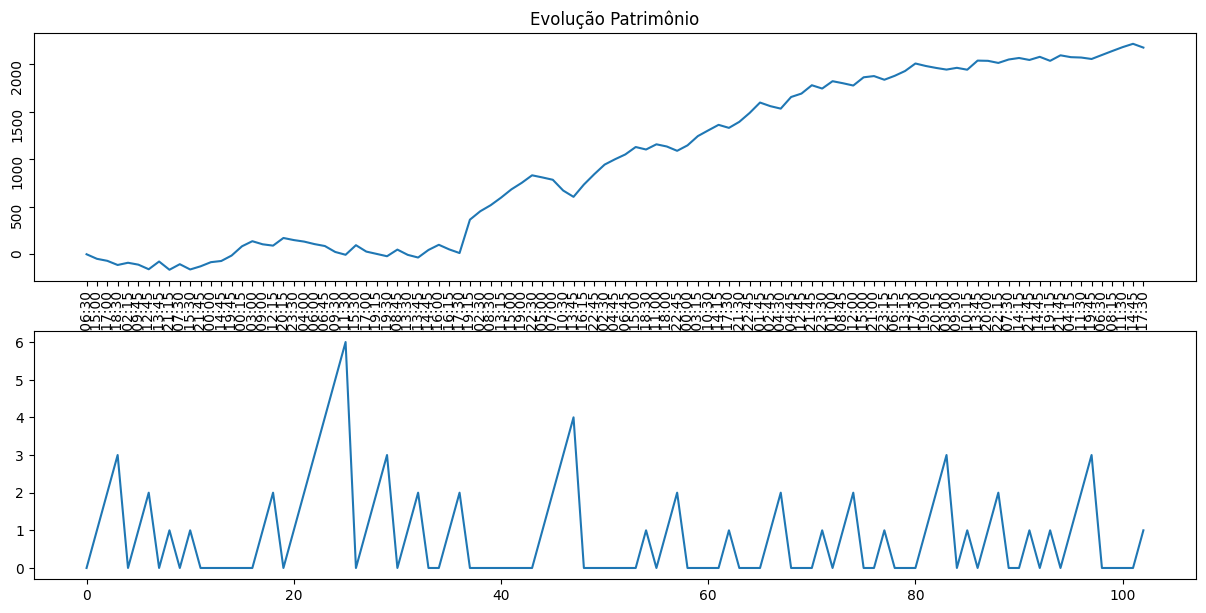

In [13]:
print(f'Acertividade: {sum(np.where(balance[0] > 0, True, False)) / sum(np.where(balance[0] != 0, True, False))*100:.2f}%')

test = np.where(balance[0] < 0, True, False)
loss_seq = [np.where(test[:key][::-1] == False)[0][0] + 1 if x == True else 0 for key, x in enumerate(test)]

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(311)
ax1.plot([x.strftime('%d/%m %H:%M') for x in balance[1][-500:]], [sum(balance[0][:x + 1]) for x in range(len(balance[0][-500:]))])
ax1.tick_params(rotation=90)
ax1.set_title('Evolução Patrimônio')

ax2 = fig.add_subplot(312)
ax2.plot([x for x in range(len(loss_seq))], loss_seq)

fig.subplots_adjust(top=1.8)
fig.show()

In [1]:
# Import libraries
from binance.client import Client
import functions.config as config
import csv
from datetime import datetime
from time import sleep

""" Create a module to write stock prices data and get real time info """

# Creating objects
client = Client(config.API_KEY, config.API_SECRET)

#candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1MINUTE)

interval = Client.KLINE_INTERVAL_1MINUTE

print('Collecting Data...')
candles = client.get_historical_klines(symbol='BTCUSDT', interval=interval, start_str='1 Jan 2017', end_str='31 Dec 2017')

print('Writting...')
csvfile = open(f'resources/dataset/2017_1min.csv', 'w', newline='')
save_csv = csv.writer(csvfile, delimiter=',')
for candlestick in candles:
    save_csv.writerow(candlestick)

csvfile.close()
print('Finished. Size:', len(candles))

Writting...
Finished. Size: 195057


In [24]:
# Cross Val

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler


SEED = 123
np.random.seed(SEED)

new_df = df.copy()
new_df['next_high'] = new_df['high_price'].shift(-1)
new_df['next_low'] = new_df['low_price'].shift(-1)
new_df['next_bull'] = new_df['Bull'].shift(-1)
new_df.dropna(inplace=True)

# Normalize the data
scaler = StandardScaler().fit(new_df.drop(['next_bull', 'next_high', 'next_low'], axis=1).copy())

X1 = scaler.transform(new_df.drop(['next_bull', 'next_high', 'next_low'], axis=1).copy())
y1 = new_df['next_bull']

cv = KFold(n_splits=15)
  
model1 = DecisionTreeClassifier(max_depth=24)
results1 = cross_validate(model1, X1, y1, cv=cv)

print(f'Accuracy classifier: {results1["test_score"].mean()*100:.2f}%')

# Normalize the data
scaler = StandardScaler().fit(new_df.drop(['next_bull', 'next_high', 'next_low', 'Bull'], axis=1).copy())

X2 = scaler.transform(new_df.drop(['next_bull', 'next_high', 'next_low', 'Bull'], axis=1).copy())
y2 = new_df['next_high']

model2 = DecisionTreeRegressor(max_depth=7)
results2 = cross_validate(model2, X2, y2, cv=cv)

print(f'Accuracy regressor: {results2["test_score"].mean()*100:.2f}%')

Accuracy classifier: 59.85%
Accuracy regressor: 99.37%
